In [1]:
import os
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm
from rasterio.windows import Window
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import CRS, Transformer

In [2]:
src_path= "path/to/your/georeferenced/image.tif"

In [4]:
data = rasterio.open(src_path)

In [5]:
data.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 7836, 'height': 7514, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.98315284119521e-06, 0.0, -122.50394699814791,
       0.0, -8.98315284119521e-06, 37.752301686363246), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

In [6]:
data.shape

(7514, 7836)

In [8]:
data.count

4

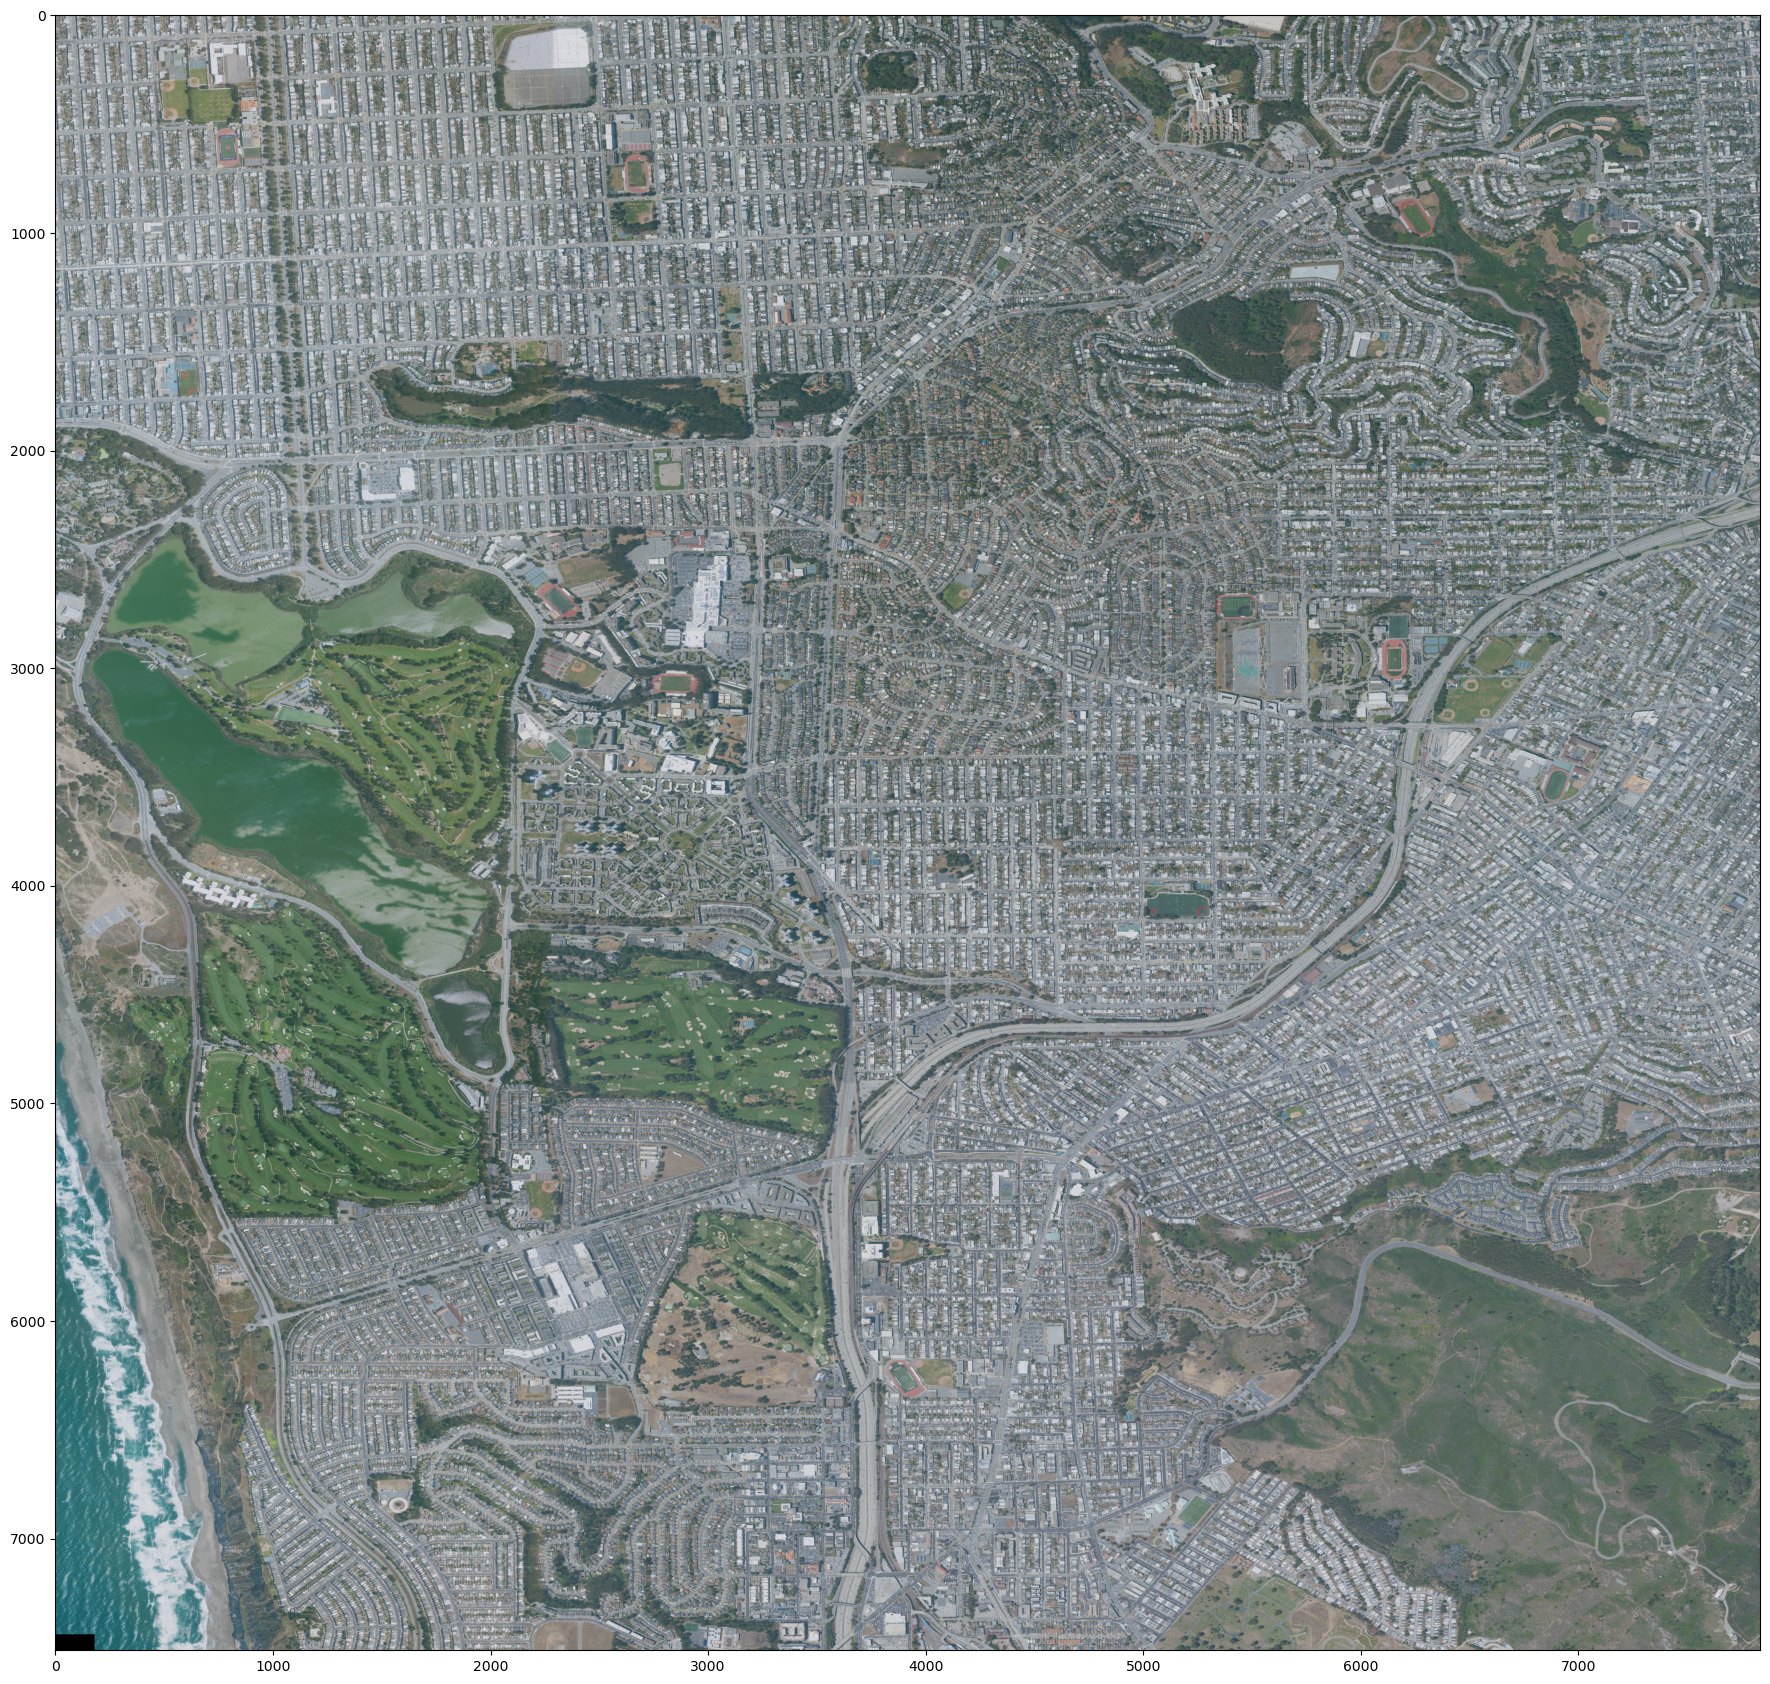

In [7]:
plt.figure(figsize=(22, 22))
plt.imshow(data.read([1,2,3]).transpose(1, 2, 0))

In [10]:
dst_image_dir = "path/to/destination/folder"
os.makedirs(dst_image_dir, exist_ok=True)

In [11]:
def get_tile_name_path(dst_dir:str, index:int):
    '''
    Generating index-specific tile name and path
    '''
    dst_tile_name = f"tile_{str(index)}.tif"
    dst_tile_path = os.path.join(dst_dir, dst_tile_name)
    return dst_tile_name, dst_tile_path

In [12]:
def get_tile_transform(parent_transform, pixel_x: int, pixel_y: int):
    '''
    Creates a tile transform matrix from the parent TIFF image
    '''
    crs_x = parent_transform.c + pixel_x * parent_transform.a
    crs_y = parent_transform.f + pixel_y * parent_transform.e
    tile_transform = rasterio.Affine(parent_transform.a, parent_transform.b, crs_x,
                                     parent_transform.d, parent_transform.e, crs_y)
    return tile_transform 

In [13]:
def get_tile_profile(parent_tif: rasterio.io.DatasetReader, pixel_x: int, pixel_y: int):
    '''
    Prepares the tile profile
    '''
    tile_crs = parent_tif.crs
    tile_nodata = parent_tif.nodata if parent_tif.nodata is not None else 0
    tile_transform = get_tile_transform(parent_tif.transform, pixel_x, pixel_y)
    profile = dict(
        driver="GTiff",
        crs=tile_crs,
        nodata=tile_nodata,
        transform=tile_transform
    )
    return profile

In [14]:
def generate_tiles(tif: rasterio.io.DatasetReader, size: int, dst_dir: str):
    for y in tqdm(range(0, tif.height, size)):
        for x in range(0, tif.width, size):
            # Creating the tile-specific profile
            profile = get_tile_profile(tif, x, y)

            # Extracting the pixel data
            tile_data = tif.read(window=((y, y + size), (x, x + size)),
                                 boundless=True, fill_value=profile['nodata'])[:3]
            dst_name, dst_tile_path = get_tile_name_path(dst_image_dir, i)
            c, h, w = tile_data.shape
            profile.update(
                height=h,
                width=w,
                count=c,
                dtype=tile_data.dtype,
                tiled='yes',
                blockxsize=size,
                blockysize=size,
                compress='lzw'
            )
            with rasterio.open(dst_tile_path, "w", **profile) as dst:
                dst.write(tile_data)
            # Rename the tile file to include the ID in the file name
            new_dst_tile_name = f"tile_{i}.tif"
            new_dst_tile_path = os.path.join(dst_dir, new_dst_tile_name)
            os.rename(dst_tile_path, new_dst_tile_path)
            i += 1

In [21]:
def generate_tiles(tif: rasterio.io.DatasetReader, size: int, dst_dir: str):
    i = 1  # Initialize 'i' inside the function
    for y in tqdm(range(0, tif.height, size)):
            x=tif.width
            profile = get_tile_profile(tif, x, y)

            # Extracting the pixel data
            tile_data = tif.read(window=((y, y + size), (0, x )),
                                 boundless=True, fill_value=profile['nodata'])[:3]
            dst_name, dst_tile_path = get_tile_name_path(dst_image_dir, i)
            c, h, w = tile_data.shape
            profile.update(
                height=h,
                width=w,
                count=c,
                dtype=tile_data.dtype,
                tiled='yes',
                blockxsize=size,
                blockysize=size,
                compress='lzw'
            )
            with rasterio.open(dst_tile_path, "w", **profile) as dst:
                dst.write(tile_data)
            # Rename the tile file to include the ID in the file name
            new_dst_tile_name = f"tile_{i}.tif"
            new_dst_tile_path = os.path.join(dst_dir, new_dst_tile_name)
            os.rename(dst_tile_path, new_dst_tile_path)
            i += 1

In [22]:
with rasterio.open(src_path) as tif:
    # Call the generate_tiles function
    generate_tiles(tif, size=4096, dst_dir=dst_image_dir) 

100%|██████████| 2/2 [00:04<00:00,  2.27s/it]


### Change Projection

In [48]:


def change_projection(input_path, output_path, target_crs):
    # Open the source raster file
    with rasterio.open(input_path) as src:
        # Get source CRS and transform
        src_crs = src.crs
        src_transform = src.transform
        src_data = src.read()

        # Define the target CRS using its WKT representation
        dst_crs = CRS.from_string(target_crs)

        # Get the bounding box in the target CRS
        transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)
        dst_bounds = transformer.transform(*src.bounds)

        # Calculate the new transform and shape
        dst_transform, dst_width, dst_height = calculate_default_transform(
            src_crs, dst_crs, src.width, src.height, *src.bounds, resolution=None
        )

        # Update metadata for the new projection
        dst_meta = src.meta.copy()
        dst_meta.update({
            'crs': dst_crs,
            'transform': dst_transform,
            'width': dst_width,
            'height': dst_height
        })

        # Create the output raster file
        with rasterio.open(output_path, 'w', **dst_meta) as dst:
            # Reproject the source data to the target CRS
            reproject(
                source=src_data,
                destination=rasterio.band(dst, 1),
                src_transform=src_transform,
                src_crs=src_crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

In [ ]:
input_image_path = 'Path/to/image'

output_image_path = 'path/to/reprojected/images'

# 'EPSG:3395' - World Mercator:
# Similar to Web Mercator but with less distortion towards the poles. 
# It's suitable for world maps with a focus on minimizing distortion in polar regions.

# 'EPSG:3035' - ETRS89 / LAEA Europe:
# This is the European Terrestrial Reference System 1989 with a Lambert Azimuthal Equal Area projection. 
# It's suitable for mapping applications focusing on Europe.
target_crs = 'EPSG:3035'  

change_projection(input_image_path, output_image_path, target_crs)